This one is getting ./AS13_reduc/data/AS13_stgdir_labelGeneric.csv

In [ ]:
pip install setfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.5 MB/s

In [ ]:
##### CONFIG ####

dataset_name = "AS13_stgdir_labelGeneric"

# note: in AS' initial tests, "s3" was used, but "s1" and "s2" have many more downloads
# "s1" has better results than "s2" in the benchmark and only 13 lgs, including FR: https://www.sbert.net/docs/pretrained_models.html
# "s2" has 50 lgs (see benchmark)

sbert_prefix = "sentence-transformers/"
sbert_model_dict = {"s1": "distiluse-base-multilingual-cased-v1", "s2": "distiluse-base-multilingual-cased-v2",
                    "s3": "distiluse-base-multilingual-cased"}

model_key = "s1"
model_ckpt = sbert_prefix + sbert_model_dict[model_key]
fraction_kept = 5 # can only be 100, 50, 25, 10, 5
run_number = 1

batch_size = 16
max_iterations_contr_learn = 20 # number of iterations for contrastive learning
max_epochs = 6

use_drive = False
save_model = False

dirname_for_drive = f"{model_ckpt}__{dataset_name}__{fraction_kept}__{run_number}"

# output dir format (below)
#output_dir=f"{model_ckpt}__finetuned__{dataset_name}__{fraction_kept}__{run_number}"

In [ ]:
assert fraction_kept in [100*x for x in (1, 0.5, 0.25, 0.1, 0.05)]
assert run_number in (1,2,3)

In [ ]:
# fraction kept to color map
clrmap_dict = {100: "Greens", 50: "Blues", 25: "Purples", 10: "Oranges", 5: "Reds"}
assert fraction_kept in clrmap_dict

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!mkdir data

In [ ]:
! pip install transformers

In [ ]:
! pip install datasets

In [ ]:
! pip install evaluate

In [ ]:
!pip install sentencepiece

In [ ]:
import os

from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, IntervalStrategy
from datasets import Features, Value, ClassLabel, Dataset, DatasetDict
import evaluate
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import torch

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer

J'ai téléversé les données sur mon serveur

In [ ]:
![[ ! -d data ]] && mkdir data || echo "data directory exists"
#![[ ! -f data/AS13_stgdir_clean.csv ]] && wget -P data https://prf1.org/stgs/as-did/AS13_stgdir_clean.csv || echo "dataset already downloaded"
![[ ! -f data/AS13_stgdir_labelGeneric.csv ]] && wget -P data https://prf1.org/stgs/as-did/AS13_stgdir_labelGeneric.csv || echo "dataset already downloaded"

data directory exists
--2023-10-19 13:42:32--  https://prf1.org/stgs/as-did/AS13_stgdir_labelGeneric.csv
Resolving prf1.org (prf1.org)... 85.214.103.246
Connecting to prf1.org (prf1.org)|85.214.103.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1017742 (994K) [text/csv]
Saving to: ‘data/AS13_stgdir_labelGeneric.csv’

AS13_stgdir_labelGe 100%[===================>] 993.89K   641KB/s    in 1.5s    

2023-10-19 13:42:34 (641 KB/s) - ‘data/AS13_stgdir_labelGeneric.csv’ saved [1017742/1017742]



Recette pour éléchargement fichiers qui sont sur Drive sur la session Colab (sans monter le Drive) (pas nécessaire ici mais comme idée pour d'autres fichiers).
C'est un fichier quelconque non relié à la tâche qui a été utilisé pour tester.

In [ ]:
mydf = "data/AS13_stgdir_labelGeneric.csv"

In [ ]:
labelCol = 'labelGeneric'

In [ ]:
import pandas as pd
AS13_df = pd.read_csv(mydf, sep="|", dtype={'description': 'object',
                                            labelCol: 'category'})

In [ ]:
AS13_df = AS13_df.drop_duplicates()
AS13_df = AS13_df.dropna(how='any')
AS13_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14613 entries, 0 to 25821
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   description   14613 non-null  object  
 1   labelGeneric  14613 non-null  category
dtypes: category(1), object(1)
memory usage: 243.2+ KB


In [ ]:
df = AS13_df

In [ ]:
df['labelGeneric'].value_counts()

music          2863
action         2467
toward         2144
exit           1295
object         1130
setting         982
delivery        962
entrance        646
movement        583
interaction     565
narration       554
aggression      350
aparte           72
Name: labelGeneric, dtype: int64

In [ ]:
# Liste de classes et ajout d'un identifiant numérique pour chaque classe
class_names = sorted(AS13_df[labelCol].unique().categories.to_list())
label2id = {class_names[i]:i for i in range(len(class_names))}
id2label = {i:class_names[i] for i in range(len(class_names))}

In [ ]:
#class_names, label2id, id2label

In [ ]:
# nv dataFrame
data_df = pd.DataFrame()
data_df['text'] = AS13_df.description
# La classe cible est la région (province) sous forme d'identifiant numérique
data_df['label'] = AS13_df[labelCol].map(label2id)

In [ ]:
data_df = data_df.reset_index(drop=True)

In [ ]:
# Transformation du DataFrame en objet de type Dataset utilisé par HuggingFace
stgtype_features = Features({'text': Value('string'),
                             'label': ClassLabel(names=class_names)})
data = Dataset.from_pandas(data_df, features=stgtype_features)

In [ ]:
# Découpage en (train + validation) (this part will be reduced to 50%, 25% and so on to compare quality) et (test).
# The test part is supposed to always stay the same size and with the same examples

In [ ]:
TRAIN_FULL, TRAIN_REDUCED = False, False
size_to_exclude = (100 - fraction_kept)/100
if size_to_exclude == 0:
  TRAIN_FULL = True
  print("FULL TRAIN")
else:
  TRAIN_REDUCED = True
  print(f"REDUCED TRAIN, KEEPING {fraction_kept}%")

REDUCED TRAIN, KEEPING 5%


In [ ]:
print(f"SIZE TO EXCLUDE IS {size_to_exclude}")

SIZE TO EXCLUDE IS 0.95


In [ ]:
if TRAIN_REDUCED:
  trainvalid_test = data.train_test_split(test_size=0.2, shuffle=True, seed=12)
  trainvalid_reduced = trainvalid_test['train'].train_test_split(test_size=size_to_exclude, shuffle=True, seed=12)
  trainvalid_reduced_trainvalid = trainvalid_reduced['train'].train_test_split(test_size=0.2, shuffle=True, seed=12)
  dataset = DatasetDict({"train": trainvalid_reduced_trainvalid["train"],
                         "valid": trainvalid_reduced_trainvalid["test"],
                         "test": trainvalid_test["test"]})
elif TRAIN_FULL:
  trainvalid_test = data.train_test_split(test_size=0.2, shuffle=True, seed=12)
  trainvalid_trainvalid = trainvalid_test["train"].train_test_split(test_size=0.2, shuffle=True, seed=12)
  dataset = DatasetDict({"train": trainvalid_trainvalid["train"],
                         "valid": trainvalid_trainvalid["test"],
                         "test": trainvalid_test["test"]})

In [ ]:
data = dataset

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 467
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 117
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2923
    })
})

In [ ]:
# this is unused unless use steps as strategy in training args
epoch_size = len(data['train'])/batch_size

In [ ]:
print(f"EPOCH SIZE IS: {epoch_size}")

EPOCH SIZE IS: 29.1875


When needed, export the dataset to verify later that it's indeed the same for all experiments

In [ ]:
from pathlib import Path

if use_drive:
  from google.colab import drive
  drive.mount("/content/drive")
  dataset_bkps = "/content/drive/MyDrive/___wv/datasets"
  os.mkdir(os.path.join(dataset_bkps, dirname_for_drive))
  for split, split_data in data.items():
    out_path = Path(dataset_bkps) / dirname_for_drive / f"{dirname_for_drive}-{split}.csv"
    print(out_path.absolute())
    split_data.to_csv(Path(dataset_bkps) / dirname_for_drive / f"{dirname_for_drive}-{split}.csv")

In [ ]:
#!head -n5 /content/drive/MyDrive/___wv/datasets/AS13_stgdir_labelGeneric_trainvalid_retest_uncased/AS13_stgdir_labelGeneric_trainvalid_retest_uncased-train.csv
#!head -n5 /content/drive/MyDrive/___wv/datasets/AS13_stgdir_labelGeneric_trainvalid_retest_uncased/AS13_stgdir_labelGeneric_trainvalid_retest_uncased-valid.csv
#!head -n5 /content/drive/MyDrive/___wv/datasets/AS13_stgdir_labelGeneric_trainvalid_retest_uncased/AS13_stgdir_labelGeneric_trainvalid_retest_uncased-test.csv

In [ ]:
# Taille du vocabulaire
#tokenizer.vocab_size

In [ ]:
# Taille de contexte maximum
#tokenizer.model_max_length

In [ ]:
from math import ceil
intended_eval_steps = ceil(len(data['train'])/batch_size)

In [ ]:
batch_size

16

In [ ]:
print(f"\n### Train with Model:[{model_ckpt}] || IterContrLrn:[{max_iterations_contr_learn}] || BatchSize:[{batch_size}] || Epochs:[{max_epochs}] ###\n")
print(f"\n### Keeping {fraction_kept}% of data. Excludes {size_to_exclude*100}% ###\n")


### Train with Model:[sentence-transformers/distiluse-base-multilingual-cased-v1] || IterContrLrn:[20] || BatchSize:[16] || Epochs:[6] ###


### Keeping 5% of data. Excludes 95.0% ###



In [ ]:
# Load SetFit model from Hub
model = SetFitModel.from_pretrained(model_ckpt)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=data['train'],
    eval_dataset=data['valid'],
    loss_class=CosineSimilarityLoss,
    batch_size=batch_size,
    num_iterations=max_iterations_contr_learn, # Number of text pairs to generate for contrastive learning
    num_epochs=max_epochs # Number of epochs to use for contrastive learning
)

In [ ]:
from datetime import datetime
start_time = datetime.now()

In [ ]:
trainer.train()
metrics = trainer.evaluate()

Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 18680
  Num epochs = 6
  Total optimization steps = 7008
  Total train batch size = 16


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1168 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1168 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1168 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1168 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1168 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1168 [00:00<?, ?it/s]

***** Running evaluation *****


In [ ]:
end_time = datetime.now()
time_diff = end_time - start_time
print(f"Training time {time_diff.total_seconds()} seconds")

In [ ]:
metrics

{'accuracy': 0.7264957264957265}

In [ ]:
# Test-set formatting and tests

test_data_as_text = data["test"].to_list()

In [ ]:
test_data_as_text[0]

{'text': "L'avocat sort.", 'label': 5}

In [ ]:
test_examples = [ve['text'] for ve in test_data_as_text]

In [ ]:
test_labels = [ve['label'] for ve in test_data_as_text]

In [ ]:
test_examples[0]

"L'avocat sort."

In [ ]:
testset_preds = model(test_examples)

In [ ]:
label_names = data['test'].features['label'].names

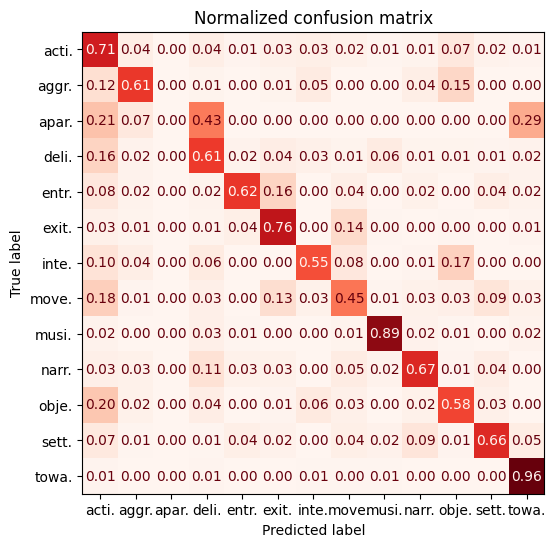

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    labels_for_fig = [l[0:4]+'.' for l in labels]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels_for_fig)
    #disp.plot(cmap="Purples", values_format=".2f", ax=ax, colorbar=False)
    disp.plot(cmap=clrmap_dict[fraction_kept], values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(testset_preds.tolist(), test_labels, label_names)

In [ ]:
print("Classification report:\n\n{}".format(classification_report(test_labels, testset_preds.tolist(), digits=4)))

Classification report:

              precision    recall  f1-score   support

           0     0.6725    0.7058    0.6888       486
           1     0.5169    0.6133    0.5610        75
           2     0.0000    0.0000    0.0000        14
           3     0.5972    0.6056    0.6014       213
           4     0.7248    0.6172    0.6667       128
           5     0.7291    0.7562    0.7424       242
           6     0.5490    0.5490    0.5490       102
           7     0.3732    0.4454    0.4061       119
           8     0.9516    0.8856    0.9174       577
           9     0.5970    0.6667    0.6299       120
          10     0.6030    0.5769    0.5897       208
          11     0.7622    0.6579    0.7062       190
          12     0.9191    0.9621    0.9402       449

    accuracy                         0.7379      2923
   macro avg     0.6151    0.6186    0.6153      2923
weighted avg     0.7411    0.7379    0.7383      2923



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for i in range(13):print(i, id2label[i], end=" ")

0 action 1 aggression 2 aparte 3 delivery 4 entrance 5 exit 6 interaction 7 movement 8 music 9 narration 10 object 11 setting 12 toward 

In [ ]:
print(f"\n### Train with Model:[{model_ckpt}] || IterContrLrn:[{max_iterations_contr_learn}] || BatchSize:[{batch_size}] || Epochs:[{max_epochs}]###\n")
print(f"\n### Keeping {fraction_kept}% of data. Excludes {size_to_exclude*100}% ###\n")


### Train with Model:[sentence-transformers/distiluse-base-multilingual-cased-v1] || IterContrLrn:[20] || BatchSize:[16] || Epochs:[6]###


### Keeping 5% of data. Excludes 95.0% ###



In [ ]:
if save_model:
  assert use_drive is True
  model.save_pretrained(f"/content/drive/MyDrive/___wv/{model_ckpt}-finetuned-stgdir-AS13reduc_50_common-testset")
  tokenizer.save_pretrained(f"/content/drive/MyDrive/___wv/{model_ckpt}-finetuned-stgdir-AS13reduc_50_common-testset")